### Name : Kshitij Chilate
### Batch : B2
### Roll No : B2-35

### Experiment 8 — Fraud Detection using Decision Trees

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_curve, average_precision_score,
roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 5)
print('Libraries imported.')

Libraries imported.


In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df = pd.read_csv(url)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Class distribution (0 = genuine, 1 = fraud):
Class
0    284315
1       492
Name: count, dtype: int64

Class distribution (%):
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


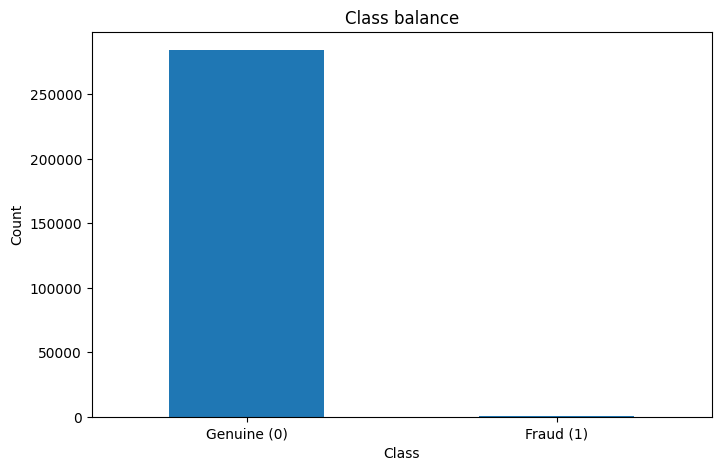

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


In [ ]:
print('Columns:', df.columns.tolist())
print('\nClass distribution (0 = genuine, 1 = fraud):')
print(df['Class'].value_counts())
print('\nClass distribution (%):')
print(df['Class'].value_counts(normalize=True) * 100)
ax = df['Class'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Genuine (0)', 'Fraud (1)'], rotation=0)
ax.set_title('Class balance')
ax.set_ylabel('Count')
plt.show()
df[['Time','Amount']].describe()

In [ ]:
X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((213605, 30), (71202, 30))

In [ ]:

num_cols = ['Amount']
remainder_cols = [c for c in X_train.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[('scale_amt', RobustScaler(), num_cols)],
    remainder='passthrough'
)


tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')


pipe = Pipeline(steps=[('prep', preprocess), ('clf', tree)])

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 6, 10, 14],
    'clf__min_samples_split': [2, 10, 50],
    'clf__min_samples_leaf': [1, 5, 20]
}


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


grid = GridSearchCV(pipe, param_grid, scoring='average_precision', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('Best AP score (cv):', grid.best_score_)
print('Best params:', grid.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best AP score (cv): 0.7563735476353806
Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 20, 'clf__min_samples_split': 2}


ROC-AUC: 0.9061104231098868

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9997    0.9963    0.9980     71079
           1     0.2778    0.8130    0.4141       123

    accuracy                         0.9960     71202
   macro avg     0.6387    0.9047    0.7060     71202
weighted avg     0.9984    0.9960    0.9970     71202

Confusion matrix:
 [[70819   260]
 [   23   100]]


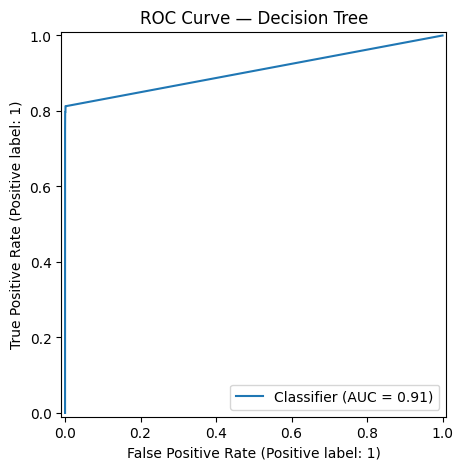

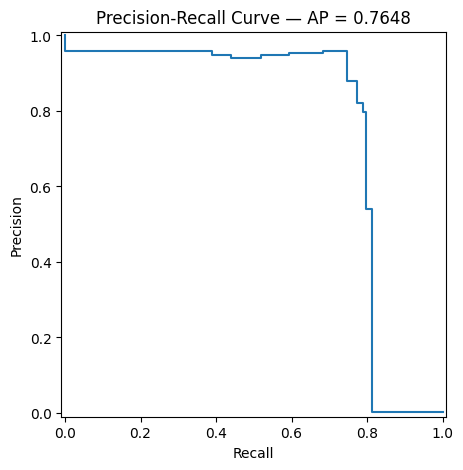

In [ ]:
# 6) Evaluate on the test set using the best model
best_model = grid.best_estimator_

# Predicted probabilities for the positive class (fraud)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Choose default threshold = 0.5 for labels; later we will explore thresholds
y_pred = (y_proba >= 0.5).astype(int)

print('ROC-AUC:', roc_auc_score(y_test, y_proba))
print('\nClassification report (threshold=0.5):')
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

# Plot ROC and PR curves
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve — Decision Tree')
plt.show()

prec, rec, thr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
PrecisionRecallDisplay(precision=prec, recall=rec).plot()
plt.title(f'Precision-Recall Curve — AP = {ap:.4f}')
plt.show()

In [ ]:
# 8) Visualize the tree (capped depth to keet it readable)

# Feature importance
for t in [0.2, 0.3, 0.4, 0.5]:
    y_hat = (y_proba >= t).astype(int)
    report = classification_report(y_test, y_hat, output_dict=True)
    p = report['1']['precision']
    r = report['1']['recall']
    f1 = report['1']['f1-score']
    print(f"threshold={t:.1f} -> precision={p:.3f}, recall={r:.3f}, f1={f1:.3f}")

threshold=0.2 -> precision=0.278, recall=0.813, f1=0.414
threshold=0.3 -> precision=0.278, recall=0.813, f1=0.414
threshold=0.4 -> precision=0.278, recall=0.813, f1=0.414
threshold=0.5 -> precision=0.278, recall=0.813, f1=0.414


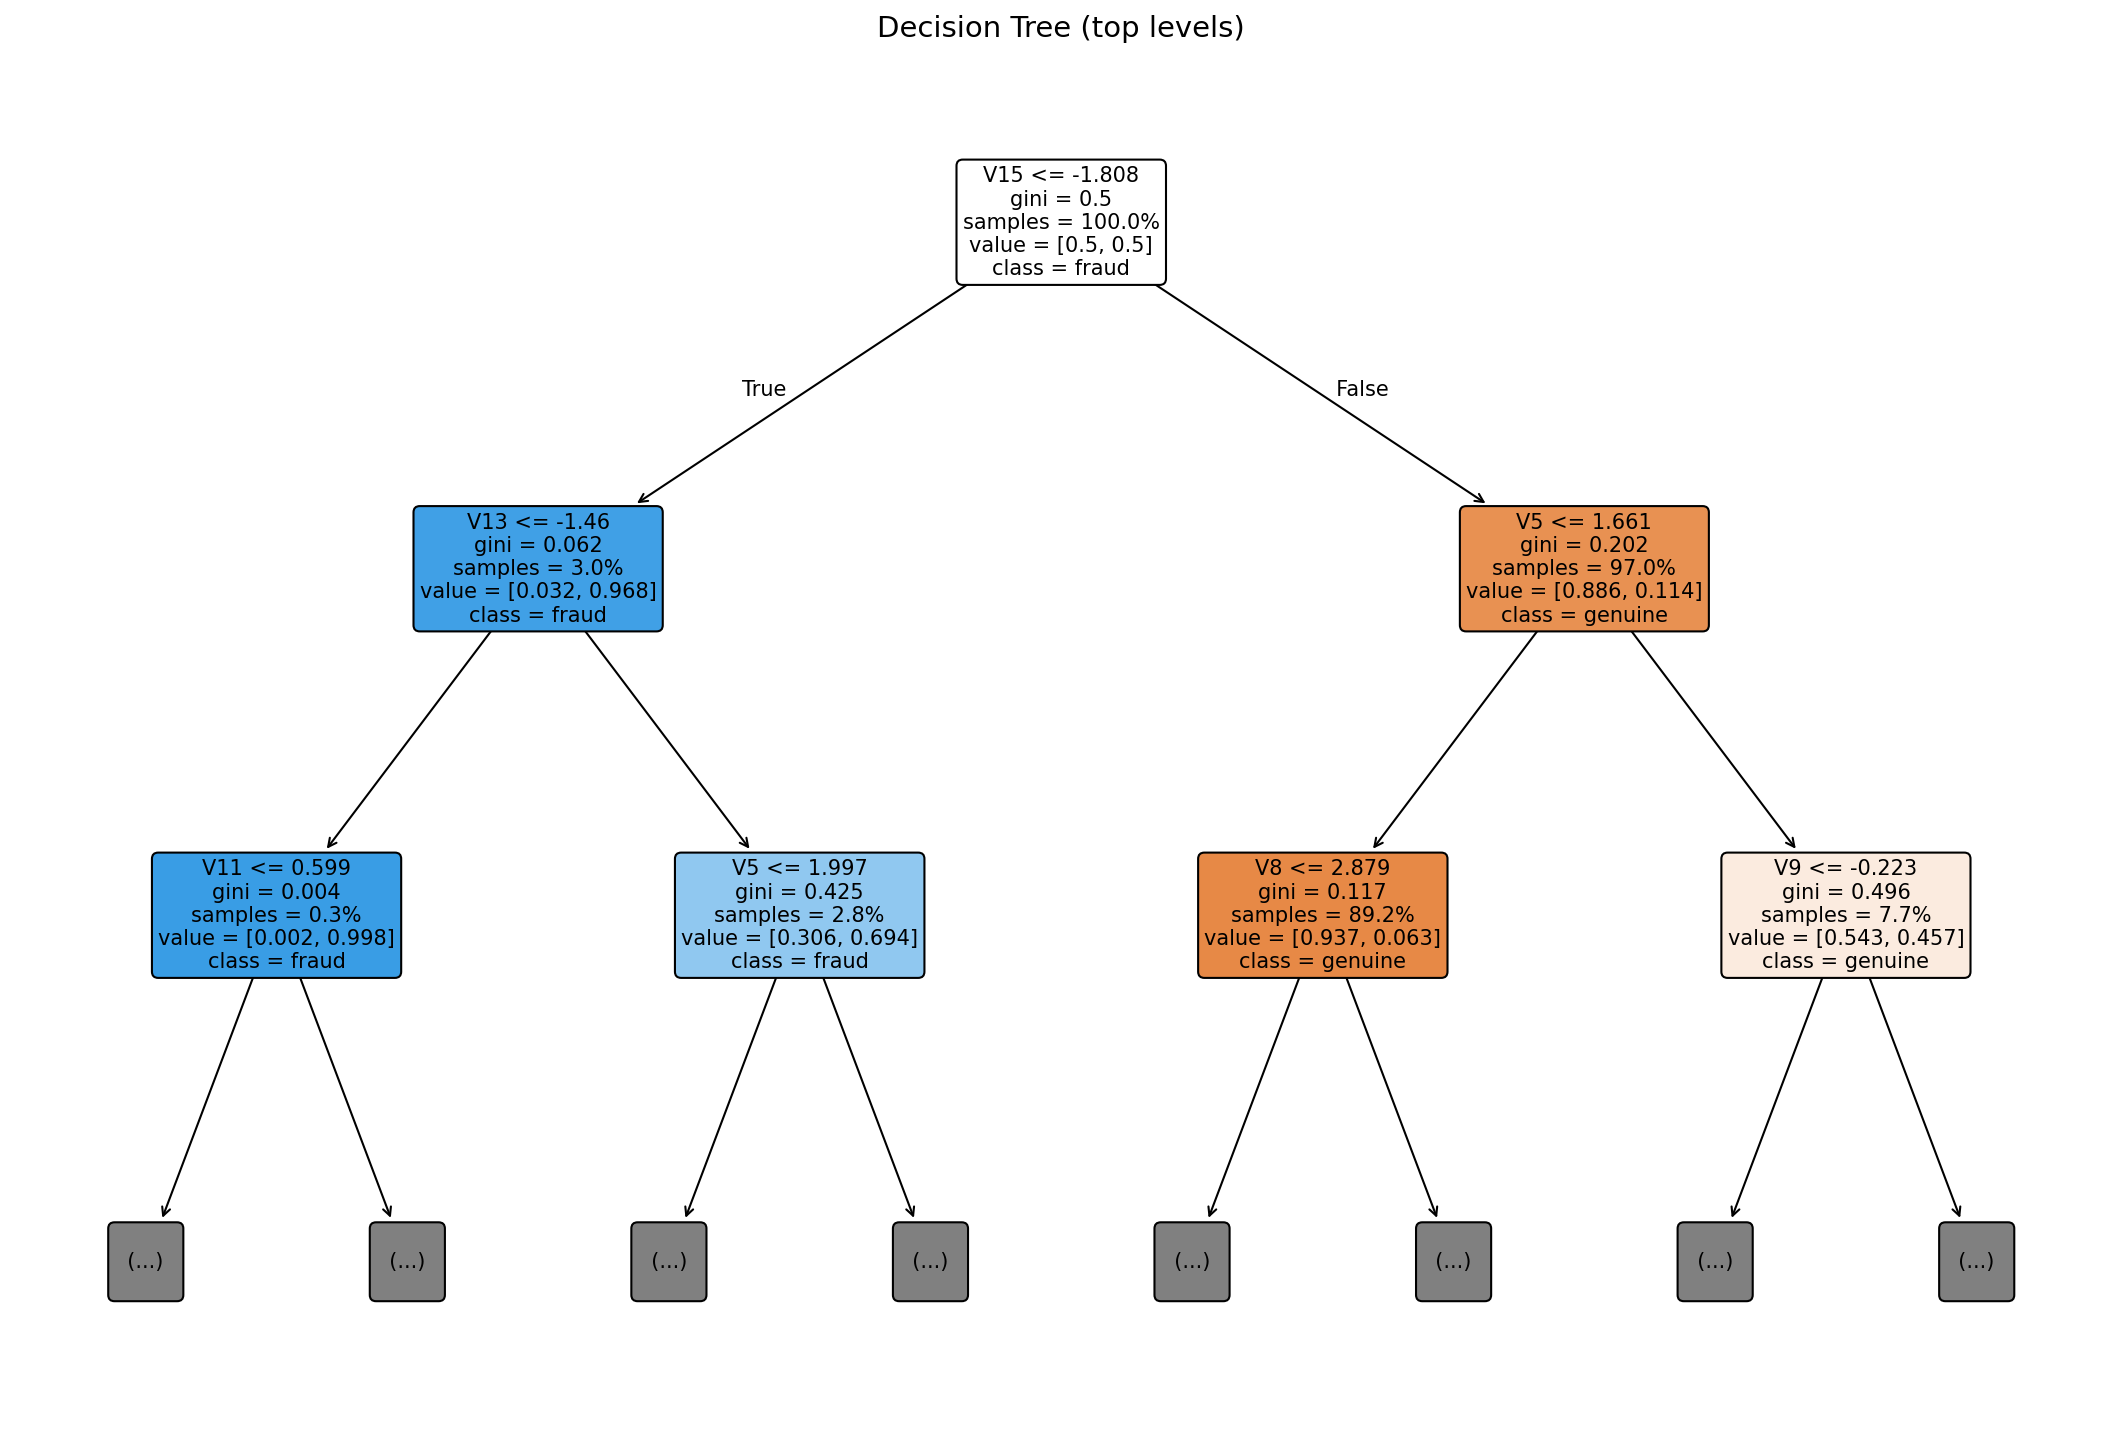

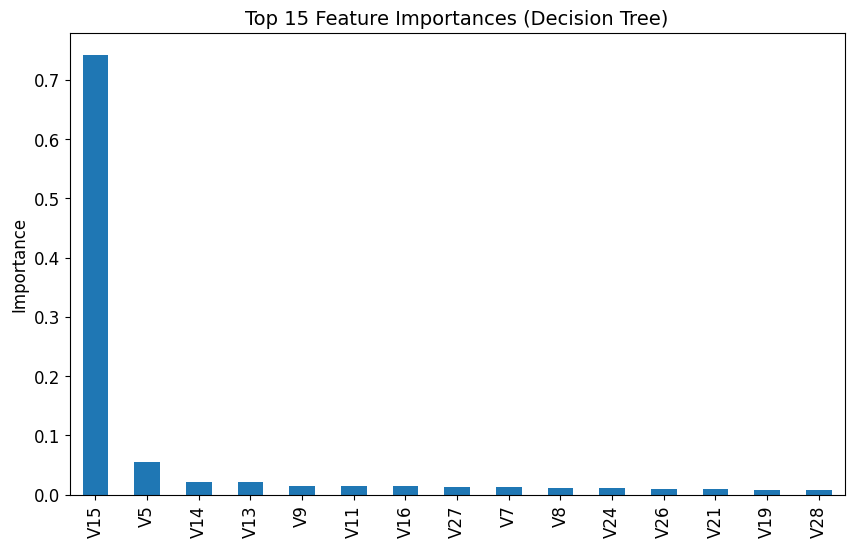

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize the decision tree with further adjustments to avoid overlap
clf = best_model.named_steps['clf']
plt.figure(figsize=(18, 12), dpi=150)  # Larger figure size to spread the tree out more
plot_tree(
    clf,
    max_depth=2,  # Further reduce the depth of the tree for readability
    filled=True,
    feature_names=X_train.columns.tolist(),
    class_names=['genuine', 'fraud'],
    fontsize=10,  # Smaller font size for better scaling
    proportion=True,  # Proportional node sizes
    rounded=True,  # Rounded nodes
    label='all',  # Shows labels for all nodes (you can try 'root' or 'none' to adjust)
)
plt.title('Decision Tree (top levels)', fontsize=14)
plt.show()

# Feature importance plot remains unchanged
importances = clf.feature_importances_
fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(15)
fi.plot(kind='bar', figsize=(10, 6), fontsize=12)
plt.title('Top 15 Feature Importances (Decision Tree)', fontsize=14)
plt.ylabel('Importance', fontsize=12)
plt.show()
